In [35]:
#! R

##import kallisto, make Poisson heatmap plot and PCA
##load libraries
libs <- c("sleuth","tidyverse","biomaRt","pheatmap","RColorBrewer","PoiClaClu","DESeq2","rhdf5","ggplot2","devtools","cowplot", "reshape2", "limma", "edgeR", "DESeq2")
libsLoaded <- lapply(libs,function(l){suppressWarnings(suppressMessages(library(l, character.only = TRUE)))})

##input parameters
BASEDIR <- "../"
DATADIR <- paste0(BASEDIR, "analysis/RNAseq")
OUTDIR <- paste0(DATADIR, "/kallisto-sleuth_any-corfit")
RDATADIR <- paste0(OUTDIR, "/RData")
SHARDATADIR <- paste0(BASEDIR, "analysis/RNAseq/shared_RData")
dir.create(RDATADIR, showWarnings=FALSE, recursive=TRUE)
dir.create(SHARDATADIR, showWarnings=FALSE, recursive=TRUE)

CLIN <- "rdl_RNAseq.metadata.tsv"
metadata <- read_tsv(CLIN) %>%
            dplyr::filter(! sampleID %in% c("S2","S12")) %>%
            dplyr::filter(! Tissue %in% c("Normal","Normal_Tumour")) %>%
            dplyr::mutate(path = file.path(DATADIR, sampleID, "kallisto", "abundance.h5")) %>%
            dplyr::rename("sample" = sampleID) %>%
            dplyr::mutate(Individual = paste0("R", Individual)) %>%
            dplyr::filter(Diet %in% "HFD") %>%
            dplyr::mutate(Int_Any = unlist(lapply(Intervention, function(f){
                                            if(f=="NO"){return("NO")}
                                            else{return("YES")}
                                    })))
 
##source plotting functions
source("https://raw.githubusercontent.com/brucemoran/R/master/functions/plot/poissonHeatmap.func.R")
source("https://raw.githubusercontent.com/brucemoran/R/master/functions/plot/pcaPlot.func.R")

##input parameters for loading sleuth data
memfree <- as.numeric(system("awk '/MemFree/ {print $2}' /proc/meminfo", intern=TRUE))
ramPerCoreGB <- 15
threadAlloc <- round((memfree/1000000)/ramPerCoreGB, 0)-1


ERROR: Error: '../data/rdl_RNAseq.metadata.tsv' does not exist in current working directory ('/data/genome/bmoran/projects/rat-diet-liraglutide_RNAseq/jupyter_notebook').


In [3]:
head(metadata)
table(metadata$Intervention)
table(metadata$Batch)

sample,Individual,Tissue,Diet,Intervention,Batch,path,Int_Any
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
S23,R11,Tumour,HFD,NO,F18FTSEUHT1008_RATetsE,../analysis/RNAseq/S23/kallisto/abundance.h5,NO
S24,R11,Tumour,HFD,NO,F18FTSEUHT1008_RATetsE,../analysis/RNAseq/S24/kallisto/abundance.h5,NO
S25,R11,Tumour,HFD,NO,F18FTSEUHT1008_RATetsE,../analysis/RNAseq/S25/kallisto/abundance.h5,NO
S26,R12,Tumour,HFD,NO,F18FTSEUHT1008_RATetsE,../analysis/RNAseq/S26/kallisto/abundance.h5,NO
S27,R12,Tumour,HFD,NO,F18FTSEUHT1008_RATetsE,../analysis/RNAseq/S27/kallisto/abundance.h5,NO
S28,R12,Tumour,HFD,NO,F18FTSEUHT1008_RATetsE,../analysis/RNAseq/S28/kallisto/abundance.h5,NO



LIR  NO RES 
  3  11   3 


F18FTSEUHT1008_RATddhE F18FTSEUHT1008_RATetsE 
                     6                     11 

In [4]:
##txp2gene annotation
##rat-human annotation
OUTPUT <- paste0(SHARDATADIR, "/tx2gene.gene2ext.human_rat_intersect_anno.RData")
if(!file.exists(OUTPUT)){
    RGENOME <- "rnorvegicus_gene_ensembl"
    HGENOME <- "hsapiens_gene_ensembl"
    rmart <- biomaRt::useMart(biomart = "ensembl", dataset = RGENOME)
    hmart <- biomaRt::useMart(biomart = "ensembl", dataset = HGENOME)

    tx2gene <- biomaRt::getBM(attributes=c("ensembl_transcript_id", "ensembl_gene_id", "external_gene_name"), mart = hmart)
    colnames(tx2gene)[1] <- "target_id"
    gene2ext <- biomaRt::getBM(attributes=c("ensembl_gene_id", "external_gene_name"), mart = hmart)

    rtx2gene <- as_tibble(biomaRt::getBM(attributes=c("ensembl_gene_id", "external_gene_name"), mart = rmart)) %>%
                dplyr::arrange(external_gene_name) %>%
                dplyr::mutate(human_external_gene_name = toupper(external_gene_name))
    htx2gene <- as_tibble(biomaRt::getBM(attributes=c("ensembl_gene_id", "external_gene_name"), mart = hmart)) %>%
                dplyr::arrange(external_gene_name) %>%
                dplyr::rename(human_external_gene_name = "external_gene_name")
    rhtx2gene <- inner_join(rtx2gene, htx2gene, by="human_external_gene_name")
    rhtx2gene <- rhtx2gene %>% dplyr::rename(ensembl_gene_id = "ensembl_gene_id.x", human_ensembl_gene_id = "ensembl_gene_id.y")
    save(rtx2gene, htx2gene, hgene2ext, rhtx2gene, file=OUTPUT)
}
if(file.exists(OUTPUT)){
    load(OUTPUT)
}


In [5]:
##read sleuth inputs
OUTPUT <- paste0(RDATADIR, "/sleuthObject.full.RData")
if(!file.exists(OUTPUT)){
    h5closeAll()
    so <- sleuth_prep(metadata,
                      full_model =~ Batch,
                      target_mapping = tx2gene,
                      aggregation_column = "ensembl_gene_id", 
                      gene_mode = TRUE,
                      num_cores = threadAlloc,
                      max_bootstrap = 50)
    save(so, metadata, file=OUTPUT)
}
if(file.exists(OUTPUT)){
    load(OUTPUT)
}

Warning message in check_quant_mode(obj, units):
"your sleuth object is in gene mode, but you selected 'est_counts'. Selecting 'scaled_reads_per_base'..."

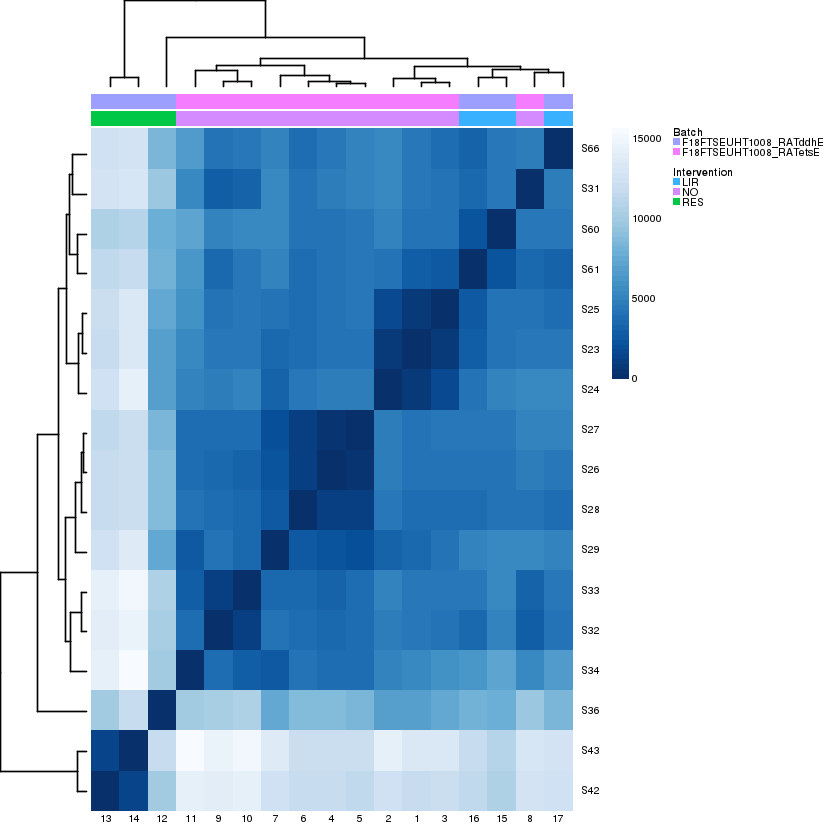

Saving 6.67 x 6.67 in image
Warning message in check_quant_mode(obj, units):
"your sleuth object is in gene mode, but you selected 'est_counts'. Selecting 'scaled_reads_per_base'..."

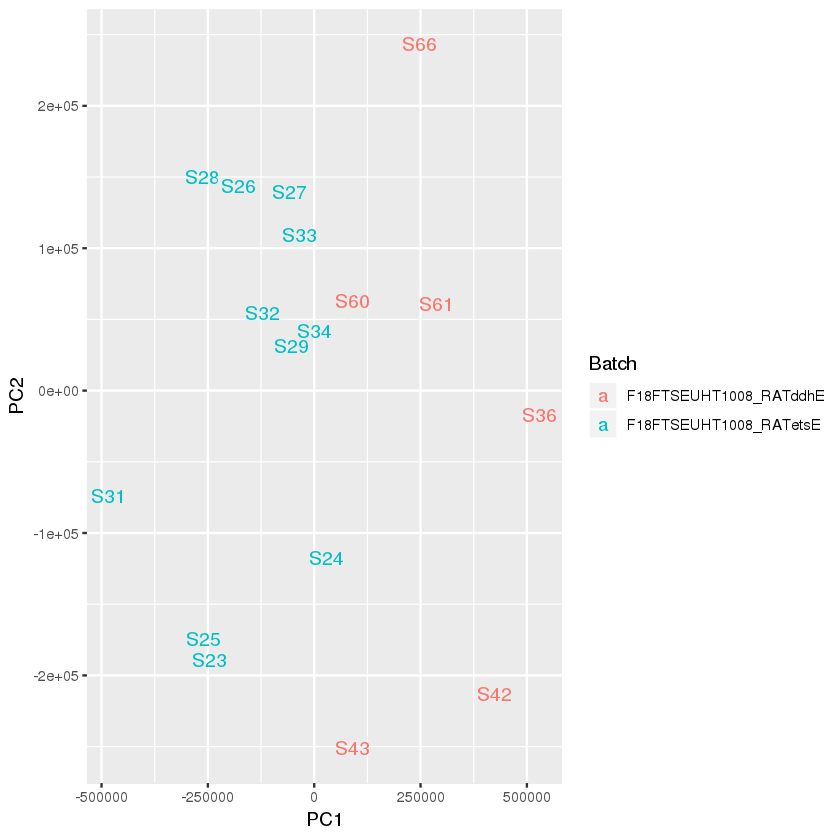

Saving 6.67 x 6.67 in image
Warning message in check_quant_mode(obj, units):
"your sleuth object is in gene mode, but you selected 'est_counts'. Selecting 'scaled_reads_per_base'..."

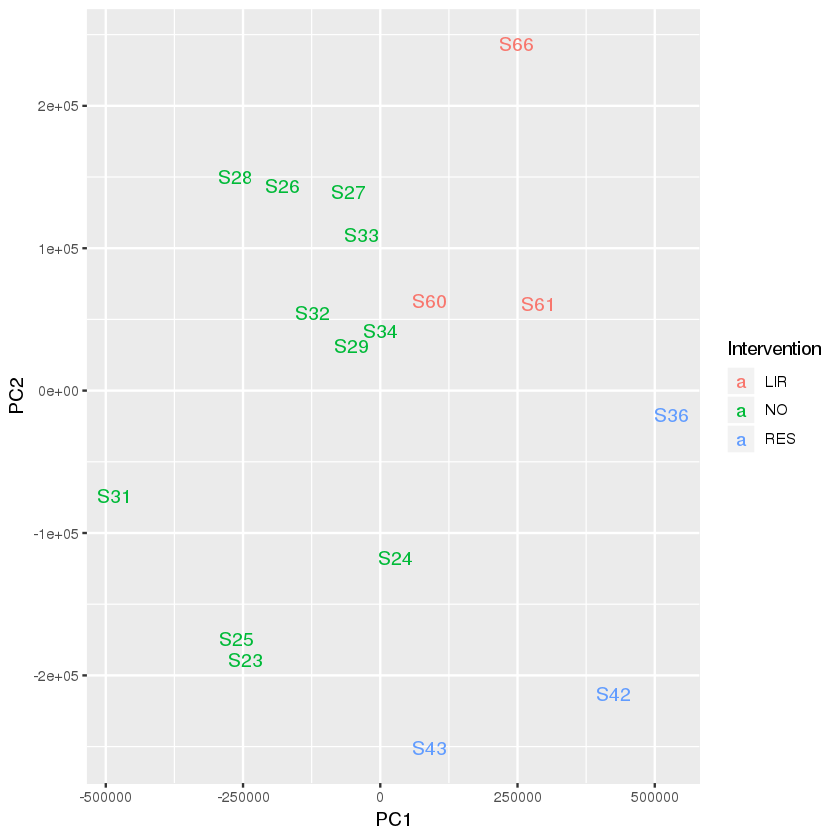

Saving 6.67 x 6.67 in image


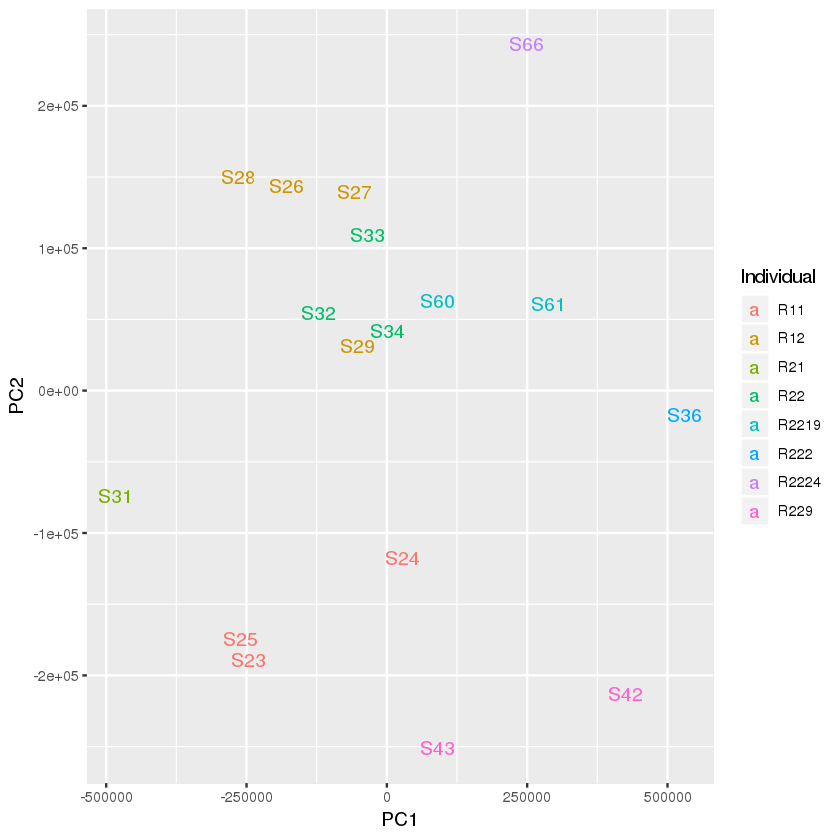

In [36]:
#QC plots
pois <- poissonHeatmap(input=so, fontsize=6, ann=metadata, anncols=c("Batch", "Intervention"))
plot_pca(so, alpha=0.3, text_labels = TRUE, color_by = "Batch"); ggsave(file="plot_pca.qc.Batch.pdf")
plot_pca(so, alpha=0.3, text_labels = TRUE, color_by = "Intervention"); ggsave(file="plot_pca.qc.Intervention.pdf")
plot_pca(so, alpha=0.3, text_labels = TRUE, color_by = "Individual"); ggsave(file="plot_pca.qc.Individual.pdf")


In [24]:
##counts from gene_mode (non-integer) sleuth object
OUTPUT <- paste0(RDATADIR, "/obs_norm_filt_df.conds.all.RData")
if(!file.exists(OUTPUT)){

    ##create DF
    obs_norm_filt_df <- dcast(so$obs_norm_filt, 
                              target_id ~ sample, 
                              value.var="scaled_reads_per_base") %>% 
                        dplyr::rename("ensembl_gene_id" = target_id) %>%
                        dplyr::arrange(ensembl_gene_id) %>%
                        dplyr::mutate_if(is.numeric, round, 0) %>%
                        as.data.frame() %>%
                        column_to_rownames(., var="ensembl_gene_id")
    
    ##input conditions
    conds <- metadata %>% dplyr::select(sample, Individual, Intervention, Int_Any, Batch) %>% as.data.frame() 
    conds[] <- lapply(conds, factor)
  
    save(obs_norm_filt_df, conds, file=OUTPUT)
}
if(file.exists(OUTPUT)){
    load(OUTPUT)
}


[1] "Sleuth filtered: 15735 genes" "Sleuth filtered: 17 genes"   
[1] "Density filtered: 14363 genes" "Density filtered: 17 genes"   


Warning message:
“Removed 2079 rows containing non-finite values (stat_density).”


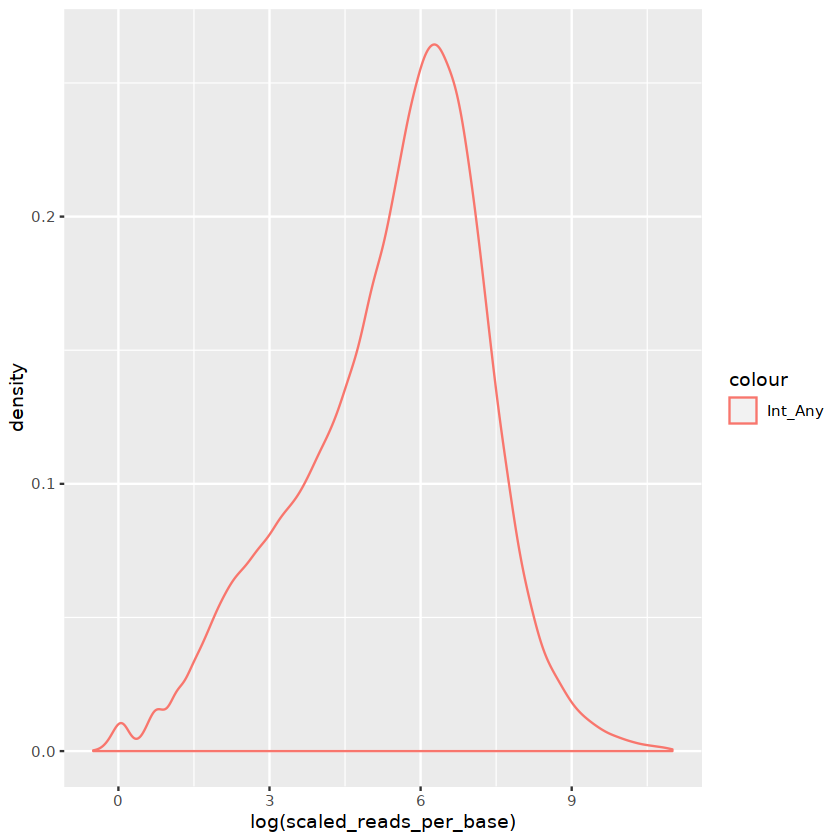

In [25]:
##distribution of log(scaled_reads_per_base) to filter low expression
OUTPUT <- paste0(RDATADIR, "/obs_norm_filt2_df.conds.RData")
if(!file.exists(OUTPUT)){
    
    ##v. similar distribution for Tissue, Batch and other factors
    ##indciates log(3) as cutoff generally, =~20 scaled_reads_per_base
    sot <- so$obs_norm_filt
    ggp <- ggplot() + 
           geom_density(data=sot, aes(log(scaled_reads_per_base), colour="Int_Any")) +
           xlim(c(-0.5,11))

    ##filter obs_norm_filt_df
    print(paste0("Sleuth filtered: ", dim(obs_norm_filt_df), " genes"))
    obs_norm_filt2_df <- as_tibble(obs_norm_filt_df, 
                                    rownames="ensembl_gene_id") %>% 
                         dplyr::mutate(mean = rowMeans(dplyr::select_if(., is.numeric))) %>%
                         dplyr::filter(mean > 20) %>% 
                         dplyr::select(-mean) %>%
                         column_to_rownames("ensembl_gene_id")
    print(paste0("Density filtered: ", dim(obs_norm_filt2_df), " genes"))

    save(ggp, obs_norm_filt2_df, conds, file=OUTPUT)
}
if(file.exists(OUTPUT)){
    load(OUTPUT)
}
ggp


In [26]:
##limma-voom including duplicateCorrelation as multiple Individuals have several replicates
OUTPUT <- paste0(RDATADIR, "/limma-voom.DGEList-corfit.RData")
if(!file.exists(OUTPUT)){
    
    ##make input model.matrix design
    mmdf <- data.frame(Contrasts=conds$Int_Any)
    all.design <- model.matrix(~0 + Contrasts, data = mmdf)
    colnames(all.design) <- c(levels(mmdf$Contrasts))
    
    ##make DGEList from filtered counts
    all.dge <- DGEList(counts=obs_norm_filt2_df)
    all.keep <- filterByExpr(all.dge, 
                             all.design)
    all.dge <- all.dge[all.keep, 
                       keep.lib.sizes=FALSE]
    all.dge <- calcNormFactors(all.dge, 
                               method="TMM")
    
    ##voom, with 2 rounds of dupcor
    all.voom <- voom(all.dge, 
                     all.design, 
                     plot = FALSE)
    all.cor <- duplicateCorrelation(all.voom, 
                                    block = conds$Individual)
    print(paste0("Duplicate correlation 1: ", all.cor$consensus.correlation))
    all.voom1 <- voom(all.dge, 
                      all.design, 
                      plot = FALSE, 
                      correlation = all.cor$consensus.correlation, block=conds$Individual)
    all.cor1 <- duplicateCorrelation(all.voom1, 
                                     block = conds$Individual)
    print(paste0("Duplicate correlation 2: ", all.cor1$consensus.correlation))

    ##fit
    all.fit <- lmFit(all.voom1, 
                     all.design, 
                     block = conds$Individual, 
                     correlation = all.cor1$consensus.correlation)
    
    save(mmdf, all.design, all.voom1, all.cor1, all.fit, file=OUTPUT)
}
if(file.exists(OUTPUT)){
    load(OUTPUT)
}


[1] "Duplicate correlation 1: 0.726432833501844"
[1] "Duplicate correlation 2: 0.726707686155075"


In [27]:
##contrasts applied to tumour, normal across desired comparisons
OUTPUT <- paste0(RDATADIR, "/limma-voom.contrastOut.RData")
if(!file.exists(OUTPUT)){

    cont.matrix <- makeContrasts(
        HFD_vs_ANY=NO-YES,
        levels=all.design)
    all.fit2 <- contrasts.fit(all.fit, cont.matrix)
    all.fite <- eBayes(all.fit2, robust=TRUE)
    contrastOut <- topTable(all.fite, number=Inf, coef="HFD_vs_ANY")
    
    contrastSig <- as_tibble(contrastOut, rownames="ensembl_gene_id") %>% 
                     inner_join(rhtx2gene,.) %>% 
                     dplyr::filter(adj.P.Val < 0.1) %>%
                     dplyr::select(ensembl_gene_id, external_gene_name, human_external_gene_name, human_ensembl_gene_id, logFC, adj.P.Val) %>%
                     dplyr::mutate_if(is.numeric, round, 3) %>%
                     dplyr::arrange(desc(logFC))

    save(contrastOut, contrastSig, all.fit2, all.fite, file=OUTPUT)

}
if(file.exists(OUTPUT)){
    load(OUTPUT)
}
dim(contrastSig)

Joining, by = "ensembl_gene_id"


[1] 18  6

In [94]:
write_excel_csv(x=contrastSig, 
                path=paste0(OUTDIR, "/rat_diet_liraglutide.Tumour_HFD_NO-ANY.DE.csv"),
                col_names=TRUE,,
                append=FALSE)


Joining, by = "ensembl_gene_id"


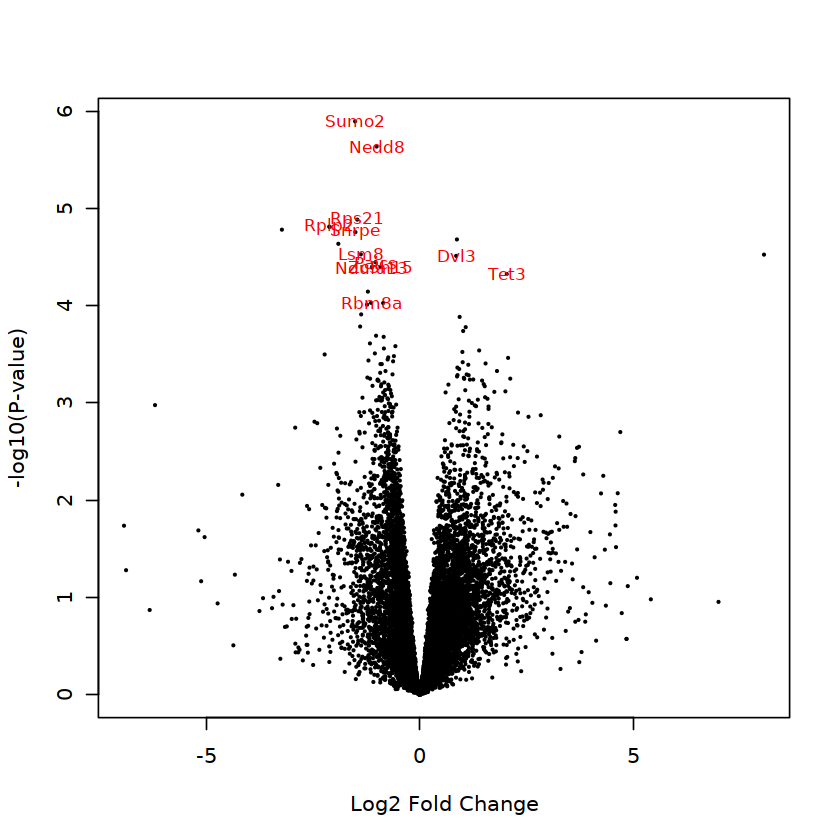

In [34]:
all.fite$names <- as_tibble(all.fite$coefficients, rownames="ensembl_gene_id") %>% 
                  left_join(., rhtx2gene) %>% 
                  dplyr::select(-human_ensembl_gene_id) %>% 
                  unique() %>% 
                  dplyr::select(external_gene_name) %>% 
                  unlist()       
pdf("volcanoplot.HFD_vs_INT-ANY.pdf")
    volcanoplot(all.fite, coef = "HFD_vs_ANY", style = "p-value", highlight = dim(contrastSig)[1], hl.col="red",
            xlab = "Log2 Fold Change", ylab = NULL, pch=16, cex=0.35, names=all.fite$names)
dev.off()


No id variables; using all as measure variables
No id variables; using all as measure variables
No id variables; using all as measure variables
No id variables; using all as measure variables
No id variables; using all as measure variables
No id variables; using all as measure variables
No id variables; using all as measure variables
No id variables; using all as measure variables


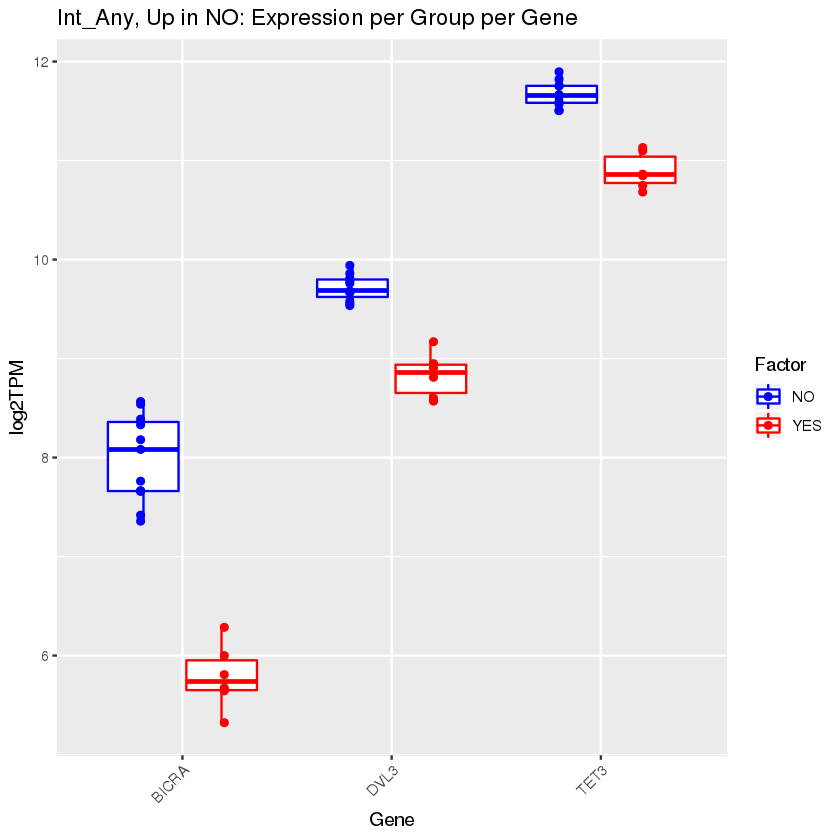

No id variables; using all as measure variables
No id variables; using all as measure variables
No id variables; using all as measure variables
No id variables; using all as measure variables
No id variables; using all as measure variables
No id variables; using all as measure variables
No id variables; using all as measure variables
No id variables; using all as measure variables
No id variables; using all as measure variables
No id variables; using all as measure variables
No id variables; using all as measure variables
No id variables; using all as measure variables
No id variables; using all as measure variables
No id variables; using all as measure variables
No id variables; using all as measure variables


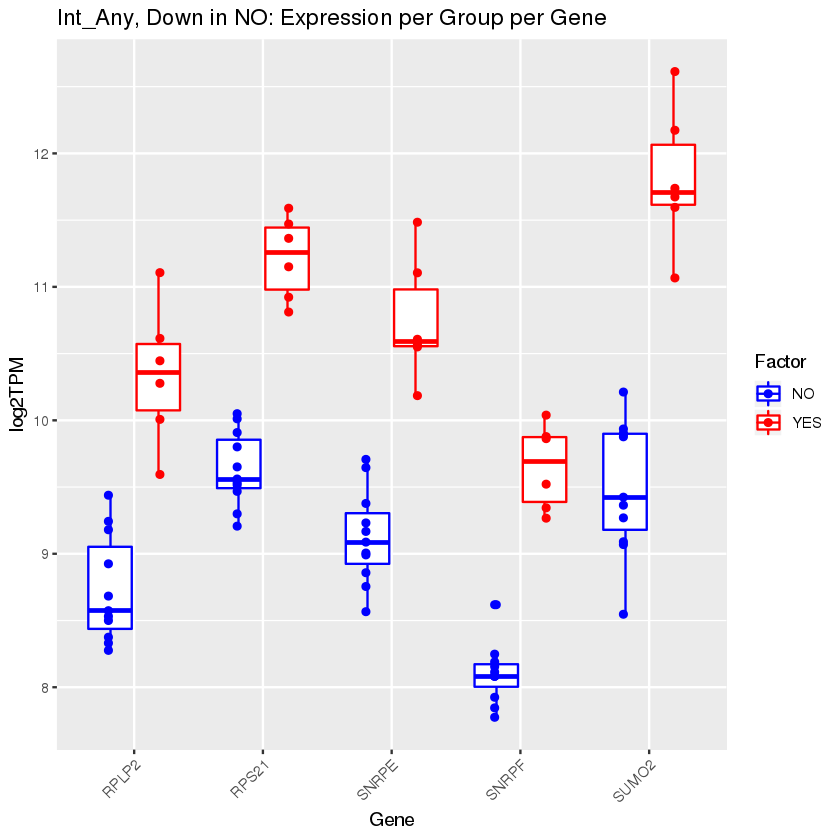

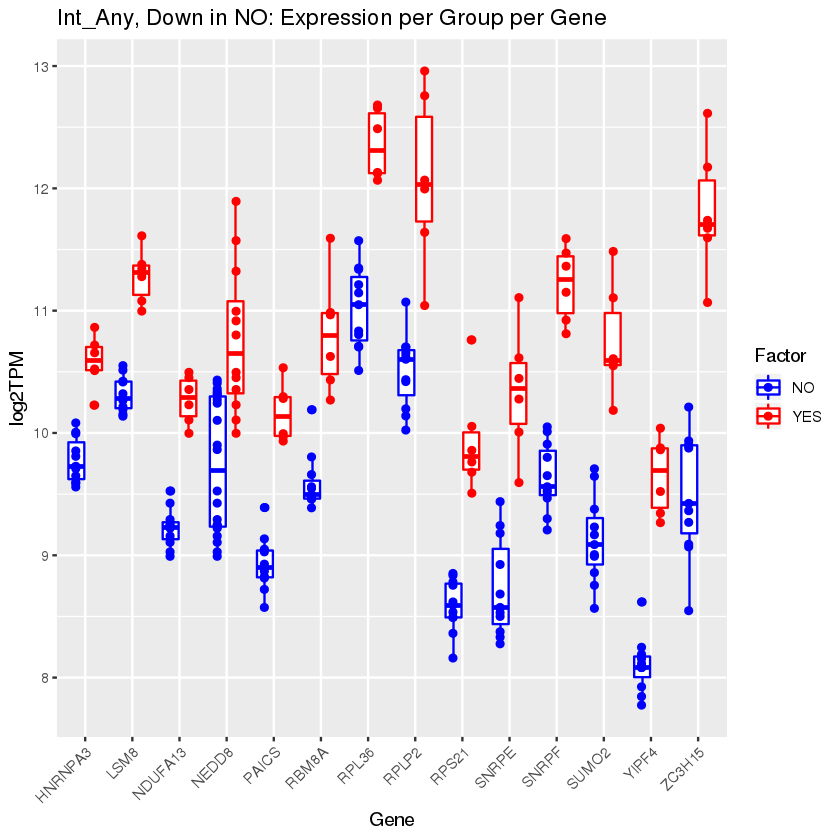

In [13]:
deleng <- dim(contrastSig)[1]
NO_vs_ANYup <- unlist(contrastSig[c(1:3), "ensembl_gene_id"])
NO_vs_ANYdown <- unlist(contrastSig[c((deleng-4):deleng), "ensembl_gene_id"])
NO_vs_ANYdownall <- unlist(contrastSig[4:deleng, "ensembl_gene_id"])

plotExps(log2(obs_norm_filt2_df), genes=NO_vs_ANYup, mapgenes=rhtx2gene, conds, condcol="Int_Any", factors=c("NO", "YES"), tag="Int_Any, Up in NO")
plotExps(log2(obs_norm_filt2_df), genes=NO_vs_ANYdown, mapgenes=rhtx2gene, conds, condcol="Int_Any", factors=c("NO", "YES"), tag="Int_Any, Down in NO")
plotExps(log2(obs_norm_filt2_df), genes=NO_vs_ANYdownall, mapgenes=rhtx2gene, conds, condcol="Int_Any", factors=c("NO", "YES"), tag="Int_Any, Down in NO")


In [12]:
plotExps <- function(log2tpms, genes, mapgenes, conds, condcol, factors, tag){

    log2tpms_genes <- log2tpms[match(genes,rownames(log2tpms)),]
    if(dim(log2tpms_genes)[1]==0){
        print("No input found, check genes are in rownames of log2tpm input")
    }
    else{
        Factor <- rep(factors[1],dim(conds)[1])
        Factor[c(conds[condcol] == factors[2])]<-factors[2]
        
        mltgg <- data.frame(0,0,0)
        mltgg <- mltgg[-1,]
        genenames <- mapgenes %>% dplyr::filter(ensembl_gene_id %in% unlist(genes)) %>% dplyr::select(human_external_gene_name)
        genenames <- unlist(genenames)

        for(xx in 1:length(genes)){
          mltgg <- rbind(mltgg, cbind(rep(genenames[xx], length(Factor)),
                                      melt(log2tpms_genes[rownames(log2tpms_genes) %in% unlist(genes)[xx],]),
                                      Factor))
        }
        
        colnames(mltgg) <- c("Gene","sample","value","Factor")
        mltgg$Factor <- factor(mltgg$Factor,
                               levels = factors, 
                               ordered = TRUE)
        ggp <- ggplot(data = mltgg, aes(x = Gene, y = value)) +
               geom_boxplot(aes(colour = Factor)) +
               geom_jitter(aes(colour = Factor), position=position_dodge(0.8)) +
               labs(y = "log2TPM", title = paste0(tag, ": Expression per Group per Gene")) +
               scale_colour_manual(values = c("blue", "red")) +
               theme(axis.text.x = element_text(angle = 45, hjust = 1))
    }
    return(ggp)
}


In [14]:
top.tibble.sig <- contrastSig
NOs <- metadata %>% dplyr::filter(Int_Any %in% "NO") %>% dplyr::select(sample) %>% unlist()
YESs <- metadata %>% dplyr::filter(Int_Any %in% "YES") %>% dplyr::select(sample) %>% unlist()

print("Mean counts per significant genes")
for(x in 1:length(top.tibble.sig$ensembl_gene_id)){
    gene <- top.tibble.sig$ensembl_gene_id[x]
    genename <- top.tibble.sig %>% dplyr::filter(ensembl_gene_id %in% gene) %>% dplyr::select("human_external_gene_name")
    NOmean <- round(rowMeans(obs_norm_filt2_df[gene, NOs]), 0)
    YESmean <- round(rowMeans(obs_norm_filt2_df[gene, YESs]), 0)
    NOsd <- round(sd(obs_norm_filt2_df[gene, NOs]), 0)
    YESsd <- round(sd(obs_norm_filt2_df[gene, YESs]), 0)
    logFC <- top.tibble.sig$logFC[x]
    print(paste0(genename, ": LogFC = ", logFC, "; NO: ", NOmean, " (sd=", NOsd, ") ; YES: ", YESmean, " (sd=", YESsd, ")"))
}


[1] "Mean counts per significant genes"
[1] "TET3: LogFC = 2.04; NO: 266 (sd=79) ; YES: 56 (sd=13)"
[1] "BICRA: LogFC = 0.936; NO: 843 (sd=77) ; YES: 461 (sd=73)"
[1] "DVL3: LogFC = 0.854; NO: 3271 (sd=289) ; YES: 1917 (sd=247)"
[1] "YIPF4: LogFC = -0.856; NO: 885 (sd=115) ; YES: 1548 (sd=227)"
[1] "ZC3H15: LogFC = -0.92; NO: 1280 (sd=129) ; YES: 2512 (sd=388)"
[1] "c(\"NEDD8\", \"NEDD8\"): LogFC = -1.009; NO: 602 (sd=67) ; YES: 1247 (sd=167)"
[1] "c(\"NEDD8\", \"NEDD8\"): LogFC = -1.009; NO: 602 (sd=67) ; YES: 1247 (sd=167)"
[1] "PAICS: LogFC = -1.032; NO: 1212 (sd=152) ; YES: 2528 (sd=780)"
[1] "NDUFA13: LogFC = -1.119; NO: 493 (sd=78) ; YES: 1164 (sd=199)"
[1] "RBM8A: LogFC = -1.139; NO: 781 (sd=143) ; YES: 1885 (sd=670)"
[1] "HNRNPA3: LogFC = -1.231; NO: 2128 (sd=493) ; YES: 5332 (sd=1051)"
[1] "RPL36: LogFC = -1.37; NO: 1484 (sd=313) ; YES: 4760 (sd=2242)"
[1] "LSM8: LogFC = -1.379; NO: 389 (sd=55) ; YES: 1024 (sd=366)"
[1] "SNRPF: LogFC = -1.394; NO: 441 (sd=131) ; YES: 1368 (sd=

In [15]:
contrastSig$ensembl_gene_id

[1] "ENSRNOG00000011387" "ENSRNOG00000011262" "ENSRNOG00000001708"
 [4] "ENSRNOG00000005610" "ENSRNOG00000005256" "ENSRNOG00000019895"
 [7] "ENSRNOG00000019895" "ENSRNOG00000002101" "ENSRNOG00000020602"
[10] "ENSRNOG00000021215" "ENSRNOG00000052968" "ENSRNOG00000033473"
[13] "ENSRNOG00000058677" "ENSRNOG00000005556" "ENSRNOG00000060449"
[16] "ENSRNOG00000031127" "ENSRNOG00000003670" "ENSRNOG00000037607"